In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the CSV file into a DataFrame
df = pd.read_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\Dicks.csv")

I initially had some issues with the list_price being very noisy. To make it easier for myself, I just set anything 

In [101]:
# Check list_price string
df['list_price'] = df['list_price'].astype(str)

# Remove the dollar sign using regex=False
df['list_price'] = df['list_price'].str.replace('$', '', regex=False)

# Remove any leading/trailing whitespace and convert to numeric
df['list_price'] = df['list_price'].str.strip()
df['list_price'] = pd.to_numeric(df['list_price'], errors='coerce')

# Optionally, drop rows where 'list_price' is NaN, and reset the index
df = df.dropna(subset=['list_price'])
df.reset_index(drop=True, inplace=True)

# print cleaned DataFrame
df.head()

,unique_id,page_number,listing_title,list_price,Unnamed: 4
0,1727460033-1,40,Nike Adult Las Vegas Aces A'ja Wilson Red Auth...,199.99,NaN
1,1727460033-2,40,Nike Adult New York Liberty Sabrina Ionescu Bl...,199.99,NaN
2,1727460033-3,40,NHL Men's 2023-2024 Stadium Series New York Is...,200.00,NaN
3,1727460033-4,40,adidas Men's Arizona State Sun Devils White Ic...,200.00,NaN
4,1727460033-5,40,NHL Men's 2023-2024 Stadium Series New York Is...,200.00,NaN


Great! Now lets see what we can learn from the data before we start putting together any features.

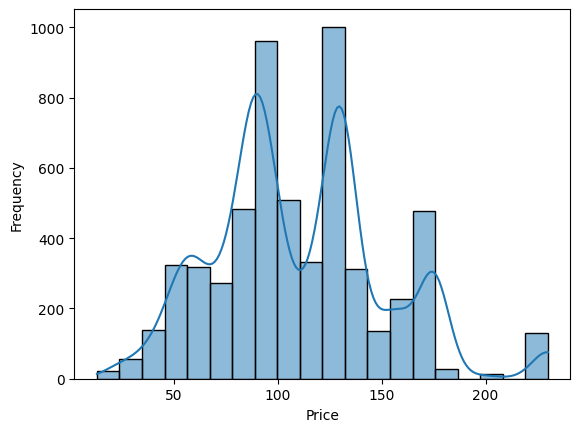

In [102]:
#generate a histogram of list_price
sns.histplot(df['list_price'], bins=20, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

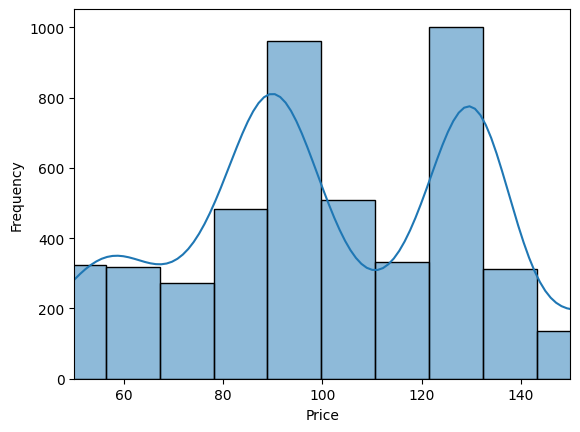

In [103]:
#generate a histogram of list prices between 50 and 150 list_price
sns.histplot(df['list_price'], bins=20, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.xlim(50, 150)
plt.show()

In [104]:
#save df to a new csv
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_cleaned.csv", index=False)

**First interesting insight!** It looks like these prices aren't evenly distributed due to pricing strategy. Meaning, there is an unusually high number of listings that are between **$90 - $100**; likely because the difference between **$85** and **$95** is pretty minimal, but going from **$90** to **<$100** is likely more noticeable to customers.

Next, I will dig into the listing_title data to see what tokens regularly occur. Then we can use those to further categorize the data into things like: **brands**, **city**, **listing_length**, **fit**

I will define each one in its respective code block.

### **brands**

From giving the listings an eye test, a few names jump out at me: *Nike*, *Adidas*, *Mitchell & Ness*. NHL listings did not have a brand attached to them, it looks like they used adidas in prior seasons before switching to Fanatics this year. I am going to assume that all NHl listings in the data are Fanatics branded.

I have clicked into maybe 15 NHL jerseys on ***DicksSportingGoods.com*** from the data and they all list Fanatics as the brand in the description on the product page.

One final note, Mitchell & Ness was acquired by Fanatics in February of 2022. But I will still break out their listings as distinct, as we can always group them back together later if we want.

In [105]:
#add a new column to the DataFrame called 'brand'
df['brand'] = df['listing_title'].str.split().str[0]

brands = ['Nike', 'Adidas', 'Under Armour', 'NHL', 'Mitchell & Ness', 'Colosseum', 'New Balance']

# Escape any special regex characters in brand names
escaped_brands = [re.escape(brand) for brand in brands]

# Join the brands into a regex pattern
brand_pattern = r'\b(?:' + '|'.join(escaped_brands) + r')\b'

# Extract the brand from the listing_title
brand_pattern = r'\b(' + '|'.join(escaped_brands) + r')\b'

#convert NHL brands to Fanatics
df['brand'] = df['brand'].str.replace('NHL', 'Fanatics', regex=False)

#convert Mitchell & Ness brands to Mitchell & Ness
df['brand'] = df['brand'].str.replace('Mitchell', 'Mitchell & Ness', regex=False)

#conver 'Under' brand to 'Under Armour'
df['brand'] = df['brand'].str.replace('Under', 'Under Armour', regex=False)

#print the count of each brand
brand_counts = df['brand'].value_counts()
print(brand_counts)

#save the cleaned DataFrame to a new CSV file
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_brands.csv", index=False)


Nike               3112
adidas              777
Fanatics            367
Mitchell & Ness     338
Colosseum           231
Under Armour        192
Prosphere           144
Jordan              139
PUMA                 92
Retro                85
Charly               51
ProSphere            43
Gen2                 28
Hummel               25
Original             19
NCAA                 19
Umbro                17
Genuine              11
Pony                 10
Mizuno                8
Tones                 7
JOMA                  6
Gameday               6
Campus                5
Athlete               3
Stitches              3
MLS                   3
New                   2
UMBRO                 2
BreakingT             2
NFL                   1
Mithcell              1
Name: brand, dtype: int64


***Great!*** So, just to explain the above. We started with the assumption that the first token in each **listing_title** would contain the brand; this is true the vast majority of the time. I then used a `regex` pattern to match any of the listed brands as whole words. This did not work out perfectly, so I had to manually fix '**Mitchell & Ness**' and '**Under Armour**'. '**NHL**' was converted to '**Fanatics**' for the reasons outlined above.

### **city**

I was considering ***team*** at first, but then realized I would not know how to identify team names without having a table to match to. Then I thought it would be easier to just track the cities. So I asked ChatGPT for a list of all American cities with at least one sports franchise. *Then*, I realized that Canadian cities have sports franchises **TOO**. So I looked those up and added: 'Toronto', 'Montreal', 'Vancouver', 'Ottawa', 'Calgary', 'Edmonton', 'Winnipeg'. 

###### Sorry Canada

In [119]:
import pandas as pd
import re

# Prepare city data
city_data = """
Anaheim,
Arlington,
Atlanta,
Baltimore,
Boston,
Buffalo,
Charlotte,
Chicago,
Cincinnati,
Cleveland,
Columbus,
Dallas,
Denver,
Detroit,
Green Bay,
Houston,
Indianapolis,
Jacksonville,
Kansas City,
Las Vegas,
Los Angeles,
Memphis,
Miami,
Milwaukee,
Minneapolis,
Nashville,
New Orleans,
New York City,
Oklahoma City,
Orlando,
Philadelphia,
Phoenix,
Pittsburgh,
Portland,
Sacramento,
Salt Lake City,
San Antonio,
San Diego,
San Francisco,
Seattle,
St. Louis,
Tampa Bay,
Washington, D.C.,
Toronto,
Montreal,
Vancouver,
Ottawa,
Calgary,
Edmonton,
Winnipeg,
NYC,
Saint Louis,
Washington DC,
DC,
New York,
San Jose
Alabama,
Alaska,
Arizona,
Arkansas,
California,
Colorado,
Connecticut,
Delaware,
Florida,
Georgia,
Hawaii,
Idaho,
Illinois,
Indiana,
Iowa,
Kansas,
Kentucky,
Louisiana,
Maine,
Maryland,
Massachusetts,
Michigan,
Minnesota,
Mississippi,
Missouri,
Montana,
Nebraska,
Nevada,
New Hampshire,
New Jersey,
New Mexico,
New York,
North Carolina,
North Dakota,
Ohio,
Oklahoma,
Oregon,
Pennsylvania,
Rhode Island,
South Carolina,
South Dakota,
Tennessee,
Texas,
Utah,
Vegas,
Vermont,
Virginia,
Washington,
West Virginia,
Wisconsin,
Wyoming,
New Jersey,
New England,
Carolina,
Golden State
Brooklyn,
Salt Lake,
New Jersey Devils
"""

# Split the 'city_data' string into lines and clean up
cities = [line.strip(',').strip() for line in city_data.strip().split('\n') if line.strip() != '']

# Build regex patterns with optional spaces, punctuation, and trailing comma
city_patterns = []
for city in cities:
    # Escape special regex characters in the city name
    city_regex = re.escape(city)
    # Replace escaped spaces with a pattern for flexible whitespace
    city_regex = city_regex.replace('\\ ', r'\s+')
    # Add optional punctuation after the city name and an optional trailing comma
    city_pattern = r'\b' + city_regex + r'[.,]?\s*'
    city_patterns.append(city_pattern)

# Combine all patterns into one
city_pattern_combined = '|'.join(city_patterns)

# Compile the regex pattern
city_regex_compiled = re.compile('(' + city_pattern_combined + ')', flags=re.IGNORECASE)

# Extract the city from 'listing_title' using the flexible regex pattern
df['city'] = df['listing_title'].str.extract(city_regex_compiled, expand=False)

# Remove any trailing punctuation and whitespace from the extracted city
df['city'] = df['city'].str.rstrip('.,').str.strip()

# Handle cases where the city is not found
df['city'] = df['city'].fillna('Unknown')

# Print the DataFrame to see the results
print(df[['listing_title', 'city']])

# Save the cleaned DataFrame to a new CSV file
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_cities.csv", index=False)

                                          listing_title       city
0     Nike Adult Las Vegas Aces A'ja Wilson Red Auth...  Las Vegas
1     Nike Adult New York Liberty Sabrina Ionescu Bl...   New York
2     NHL Men's 2023-2024 Stadium Series New York Is...   New York
3     adidas Men's Arizona State Sun Devils White Ic...    Arizona
4     NHL Men's 2023-2024 Stadium Series New York Is...   New York
...                                                 ...        ...
5744  Colosseum Toddler Kansas State Wildcats Purple...     Kansas
5745  Colosseum Toddler Pitt Panthers Royal Field Ti...    Unknown
5746  Colosseum Toddler Purdue Boilermakers Black Fi...    Unknown
5747  Colosseum Toddler Iowa Hawkeyes Black Field Ti...       Iowa
5748  Colosseum Toddler UCLA Bruins Blue Beta Fleece...    Unknown

[5749 rows x 2 columns]


Now we can reference the city inside of each `listing_title` string

In [120]:
#print the count of each city
city_counts = df['city'].value_counts()
print(city_counts)

#print listing_title of unknowns, let me see the full listing_title
unknowns = df[df['city'] == 'Unknown']
print(unknowns['listing_title'])




Unknown         1475
New York         254
Los Angeles      190
Philadelphia     175
Pittsburgh       136
                ... 
New Mexico         2
North Dakota       2
Ottawa             1
Winnipeg           1
Nevada             1
Name: city, Length: 90, dtype: int64
19      Under Armour Men's Notre Dame Fighting Irish N...
265     adidas Adult Mexico Guillermo Ochoa #13 Home A...
271     adidas Adult 2024 MLS All-Star Game Lionel Mes...
280     adidas Adult Austin FC Sebastian Driussi #10 S...
282     NHL Adult 2022 Stanley Cup Champions Cale Maka...
                              ...                        
5741    Colosseum Toddler UCF Knights Black Field Time...
5742    Colosseum Toddler Louisville Cardinals Red Fie...
5745    Colosseum Toddler Pitt Panthers Royal Field Ti...
5746    Colosseum Toddler Purdue Boilermakers Black Fi...
5748    Colosseum Toddler UCLA Bruins Blue Beta Fleece...
Name: listing_title, Length: 1475, dtype: object


# Problem
I realized just a moment ago that of the 5,749 listings some of them would not be from major leagues, **DUHH**. College jerseys are a bit harder to pinpoint city, since in almost all cases, the name of the school takes its place. I now have a decision: Cut college jerseys and move on to the next feature, figure out a way to look up D1 college names against strings in `listing_title`.

Choosing the latter would probably require more than twice as much effort as I have already put into this feature. **ALSO**, I stupidly didn't realize that there are tons of non-American sports jerseys that sell at Dick's. **DUHH AGAIN**. These, mainly soccer, jerseys would be a challenge to categorize as well because there is so much variation in the naming schemes of these teams. They are sometimes named directly after a city, sometimes not; national team jerseys would need a separate library of countries to reference.

Anywho, what I did do is manually go through and mark cities/regions that chatGPT and I missed the first time around; they will be in the above code, since I went back and added them :)

- "Vegas Golden Knights" - I added 'Vegas' to `cities` and marked down to rename 'Vegas' to 'Las Vegas' in `df`
- "New England Patriots" - Ugh, couldn't be the Boston Patriots, guys? Maybe not completely precise, but I will change this to 'Boston' in `df`
- "Carolina Panthers" & "Carolina Hurricanes" - Lazily, I am just going to leave these as 'Carolina'.
- "Golden State" - SF
- "Brooklyn Nets" - NY
- "Real Salt Lake" - Salt Lake City
- "New Jersey Devils" - Newark


I am sure I missed some, but now lets make those above fixes and drop the unknowns.

In [124]:
#Drop rows from df where city is unknown
df = df[df['city'] != 'Unknown']

#change 'Vegas' to 'Las Vegas'
df['city'] = df['city'].str.replace('Vegas', 'Las Vegas', regex=False)

#change 'new england' to 'Boston'
df['city'] = df['city'].str.replace('New England', 'Boston', regex=False)

#change 'Golden State' to 'San Francisco'
df['city'] = df['city'].str.replace('Golden State', 'San Francisco', regex=False)

#change 'Brooklyn' to 'New York City'
df['city'] = df['city'].str.replace('Brooklyn', 'New York City', regex=False)

#change 'Salt Lake' to 'Salt Lake City'
df['city'] = df['city'].str.replace('Salt Lake', 'Salt Lake City', regex=False)

#change 'New Jersey' to 'Newark'
df['city'] = df['city'].str.replace('New Jersey', 'Newark', regex=False)


#save the cleaned DataFrame to a new CSV file
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_cities_cleaned.csv", index=False)

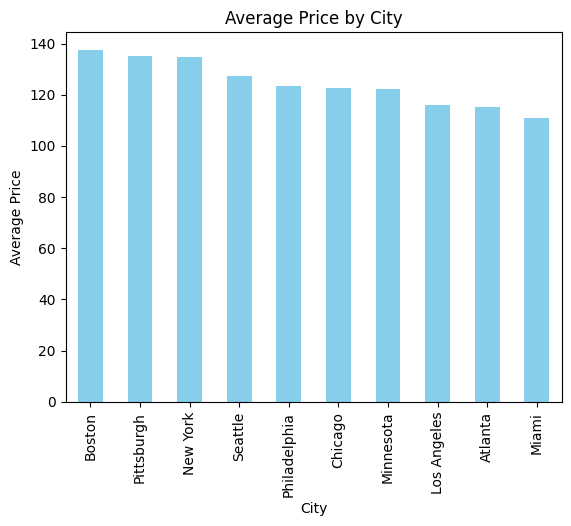

In [131]:
#generate a histogram of average price by city, but only the ten cities with the most listings
top_cities = df['city'].value_counts().head(10).index
df_top_cities = df[df['city'].isin(top_cities)]
avg_price_by_city = df_top_cities.groupby('city')['list_price'].mean().sort_values(ascending=False)
avg_price_by_city.plot(kind='bar', color='skyblue')
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Average Price by City')
plt.show()



Boston and New York in the top three tracks, but Pittsburgh is a surprise. Though, maybe there is a chance that Pitt's love of black and yellow leads their fans to buying more jerseys!~

## Listing_Length
I thought this would be a fun one to track because it is a super simple calculation, and it might tell us something interesting about whether or not more or less listing copy leads to customers being okay with higher prices.

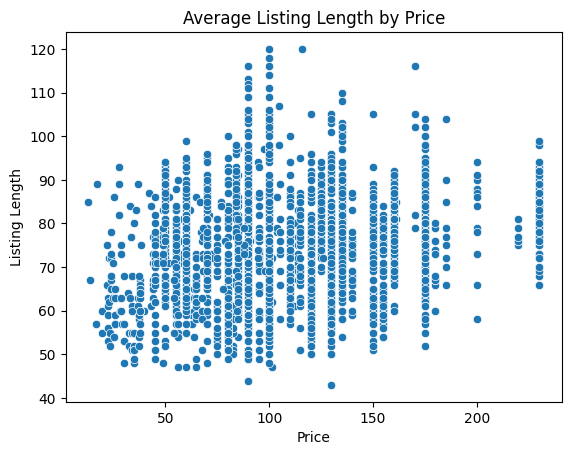

0.23212744184303563


In [137]:
#add a column to df named listing_length that contains the length of the listing_title
df['listing_length'] = df['listing_title'].str.len()

#generate a plot of average listing_length by list_price
sns.scatterplot(data=df, x='list_price', y='listing_length')
plt.xlabel('Price')
plt.ylabel('Listing Length')
plt.title('Average Listing Length by Price')
plt.show()

#check the correlation between listing_length and list_price
correlation = df['list_price'].corr(df['listing_length'])
print(correlation)



Looks like my listing_length theory isn't playing out. 0.232 is a quite weak positive signal, meaning, the more characters in the title the higher the price; not by much, though.  

## fit
This one is really just for fun and I thought it would be quick. If we check for the appearance of: 'Mens', 'Womens', 'Toddler', 'Youth' in listing_title I am curious what it would tell us.

In [149]:
#check for 'Men's', 'Women's', 'Toddler', 'Youth', 'Infant' in listing_title and add it to a new column named fit
df['fit'] = df['listing_title'].str.extract(r'\b(Men\'s|Women\'s|Toddler|Youth|Infant|little kid|Adult)\b', expand=False)

#replace 'little kid' with 'Youth'
df['fit'] = df['fit'].str.replace('little kid', 'Youth', regex=False)

#print the count of each fit
fit_counts = df['fit'].value_counts()
print(fit_counts)

#save the cleaned DataFrame to a new CSV file
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_fit.csv", index=False)

Men's      2123
Youth      1046
Adult       387
Women's     368
Toddler     117
Infant       10
Name: fit, dtype: int64


In [150]:
#save a final clean version of the DataFrame to a new CSV file
df.to_csv(r"C:\Users\kflac\Desktop\Dicks sporting goods\DSG_final.csv", index=False)